# Pre-processing

In [1]:
'''
    This section is designed to adequate the dataset to the tensorflow
    input format so that will be possible to build a classification
    model with tensorflow.

    After adequation, a model is built using the keras API.
'''

import tensorflow as tf
import glob
import pickle
from tensorflow.keras import layers, Model, metrics, regularizers, optimizers
from random import shuffle

In [2]:
DATASET_SIZE = 1203
BATCH_SIZE = 16
TRAIN_SIZE = 960
NUM_EPOCHS = 10
NUM_CLASSES = 2

filenames_list = []
labels_list = []

filenames_list = glob.glob("./lfwcrop_color/labeled_faces/*.jpg")
shuffle(filenames_list)

# last image of the non-smile list
divisor = './lfwcrop_color/labeled_faces/Jacques_Chirac_0001.jpg'

#  Mounting the filenames and the labels list
for i in range(len(filenames_list)):
    if filenames_list[i] > divisor:
        labels_list.append(1)
    else:
        labels_list.append(0)

In [3]:
# A vector of filenames.
filenames = tf.constant(filenames_list)

# 'labels[i]' is the label for the image in 'filenames[i]'.
labels = tf.constant(labels_list)
labels = tf.one_hot(tf.cast(labels, tf.int32), NUM_CLASSES)

In [4]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize_images(image_decoded, [64, 64])
    std_image = tf.image.per_image_standardization(image_resized)
    return std_image, label

In [5]:
def create_dataset(filenames, labels):
    # Generating tf.data.Dataset object and shuffling it
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)

    return dataset

In [6]:
def train_test_split(dataset):
    # defining batch size and 'count' number of epochs
    # taking ~ 80% for training and ~ 20% for testing
    train_data = dataset.take(TRAIN_SIZE) 
    train_data = train_data.batch(batch_size=BATCH_SIZE)
    train_data = train_data.repeat()

    test_data = dataset.skip(TRAIN_SIZE)
    test_data = test_data.batch(batch_size=BATCH_SIZE)
    test_data = test_data.repeat()

    return train_data, test_data

In [7]:
dataset = create_dataset(filenames,labels)
train_data, test_data = train_test_split(dataset)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# Model

In [8]:
# --------- MODEL -------------

# Inputs
inputs = tf.keras.Input(shape=(64,64,3))

# Convolutional Layer 1
conv1 = layers.Conv2D(filters=32, kernel_size=[3,3], padding='same', activation=tf.nn.relu)(inputs)

# Pooling Layer 1
pool1 = layers.MaxPool2D(pool_size=(2,2), strides=2)(conv1)

# Convolutional Layer 2
conv2 = layers.Conv2D(filters=64, kernel_size=[3,3], activation=tf.nn.relu)(pool1)

# Pooling Layer 2
pool2 = layers.MaxPool2D(pool_size=(2,2), strides=2)(conv2)

# Convolutional Layer 2
conv3 = layers.Conv2D(filters=128, kernel_size=[3,3], activation=tf.nn.relu)(pool2)

# Pooling Layer 2
pool3 = layers.MaxPool2D(pool_size=(2,2), strides=2)(conv3)

# Flattening
pool3_flat = layers.Flatten()(pool3)

# Dense Layer 1
dense1 = layers.Dense(512, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.0012))(pool3_flat)

# Dropping out with a probability of 'rate'
dropped = layers.Dropout(rate=0.5)(dense1)

# output Layer
predictions = layers.Dense(NUM_CLASSES, kernel_regularizer=regularizers.l2(0.0012),
                           activation=tf.nn.softmax)(dropped)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
# -------- MODEL PARAMETERS ---------

model = Model(inputs=inputs, outputs=predictions)

# Instantiating an ADAM Optimizer
adam = optimizers.Adam(lr=0.001)

model.compile(loss=metrics.binary_crossentropy, optimizer=adam, metrics=[metrics.categorical_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
__________

# Training

In [10]:
H = model.fit(
    train_data,
    epochs=NUM_EPOCHS,
    steps_per_epoch=60,
    validation_data=test_data,
    validation_steps=15
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60/60 [==============================] - 20s 327ms/step - loss: 0.8531 - categorical_accuracy: 0.8531 - val_loss: 0.4381 - val_categorical_accuracy: 0.9500
Epoch 2/10
60/60 [==============================] - 16s 260ms/step - loss: 0.3947 - categorical_accuracy: 0.9458 - val_loss: 0.3210 - val_categorical_accuracy: 0.9559
Epoch 3/10
60/60 [==============================] - 12s 208ms/step - loss: 0.3047 - categorical_accuracy: 0.9490 - val_loss: 0.2774 - val_categorical_accuracy: 0.9471
Epoch 4/10
60/60 [==============================] - 12s 197ms/step - loss: 0.2162 - categorical_accuracy: 0.9750 - val_loss: 0.2215 - val_categorical_accuracy: 0.9692
Epoch 5/10
60/60 [==============================] - 13s 220ms/step - loss: 0.1688 - categorical_accuracy: 0.9823 - val_loss: 0.1838 - val_categorical_accuracy: 0.9648
Epoch 6/10
60/60 [==============================] - 12s 200ms/step - loss: 0.1461 - categorical_accuracy: 0.9823 - va

# Results

### Training Loss and Accuracy

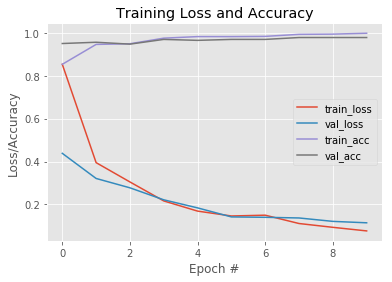

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the curve Epoch vs. Loss/Accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Confusion matrix

In [12]:
predictions = model.predict(test_data, steps=16)

# apply a step function to threshold the outputs to binary
# class labels
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

# extracting all labels of the test_data dataset
lab = tf.constant(labels_list[TRAIN_SIZE:DATASET_SIZE])

predicted = []

for i in range(len(predictions)):
    if predictions[i][0] == 0:
        predicted.append(1)
    else:
        predicted.append(0)
        
# Transforming the predictions into a tensor to use tf.confusion_matrix
predicted = tf.constant(predicted)

In [13]:
confusion = tf.confusion_matrix(lab, predicted, num_classes=NUM_CLASSES)
sess = tf.Session()
with sess.as_default():
        print(sess.run(confusion))

Instructions for updating:
Use tf.cast instead.
[[117   5]
 [  1 120]]


# Predictions with evaluation_faces dataset

In [14]:
files_ls = []
files_ls = sorted(glob.glob("./lfwcrop_color/evaluation_faces/*.jpg"))

labels_ls = []

for i in range(len(files_ls)):
    if i+1 <= 10:
        labels_ls.append(1)
    else:
        labels_ls.append(0)

In [15]:
# A vector of filenames.
samples = tf.constant(files_ls)

# 'labels[i]' is the label for the image in 'filenames[i]'.
label = tf.constant(labels_ls)
label = tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES)

In [16]:
eval_data = create_dataset(samples, label)
eval_data = eval_data.batch(batch_size=len(labels_ls))

predictions = model.predict(eval_data, steps=1)

# apply a step function to threshold the outputs to binary
# class labels
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

In [17]:
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

# Saving the Model

In [22]:
from tensorflow.keras import models

models.save_model(model,'model')

# NOT USING model.save because:
# WARNING:tensorflow:TensorFlow optimizers do not make it possible to access optimizer 
# attributes or optimizer state after instantiation.
# As a result, we cannot save the optimizer as part of the model save file. 
# You will have to compile your model again after loading it. 
# Prefer using a Keras optimizer instead (see keras.io/optimizers).

# NOT USING pickle because can't pickle.RLock object